# Character-Level Language Model for Name Generation

This document explains the process of creating a simple character-level language model using a neural network to generate new names based on a provided dataset. We will cover the steps involved in data preparation, defining the model's architecture, training the model, and finally, generating new names.

The fundamental idea behind this type of model is to learn the probability of the *next character* in a sequence given a few preceding characters. By understanding these probabilities, the model can then "compose" new sequences that statistically resemble the original data.

## 1. Data Loading and Vocabulary Creation

The first step in any machine learning project is to prepare the data.
1.  **Loading Names:** We start by reading a list of names from a text file, assuming each name is on a new line. This forms our raw dataset.
2.  **Building a Vocabulary:** From all the loaded names, we extract every unique character. This collection of unique characters forms our 'vocabulary'. For example, if our names are "Anna" and "Bob", our vocabulary would include 'A', 'n', 'a', 'B', 'o', 'b'.
3.  **Character-to-Integer Mapping (and vice-versa):** To enable our neural network to process text, we need to convert characters into numerical representations. We create two mappings:
    *   **`s2i` (string-to-integer):** Assigns a unique integer ID to each character in our vocabulary.
    *   **`i2s` (integer-to-string):** Allows us to convert these integer IDs back to characters, which is useful for generating human-readable names.
4.  **Special End-of-Name Token:** We introduce a special character, often represented as a dot (`.`), and assign it the integer ID 0. This special token serves two crucial purposes:
    *   **Start/End of Name:** By adding this token to the beginning and end of names during training, the model learns the concept of a name's boundaries.
    *   **Stopping Generation:** When the model generates this token during inference, it signals that the generated name is complete.

## 2. Preparing Training Data: Context-Target Pairs

Neural networks learn by being shown input-output examples. For a character-level model, the input is a sequence of characters (the 'context'), and the output is the single character that follows this context (the 'target').

1.  **Context Window:** We define a `context_window` size, which specifies how many preceding characters the model should consider when predicting the next one. If the `context_window` is 3, the model looks at the previous three characters.
2.  **Iterating Through Names:** For each name in our dataset:
    *   We append the special `.` token to the end of the name. This is vital for teaching the model when a name should stop.
    *   We then iterate through each character in this extended name.
3.  **Creating Examples:** For every character `C` in a name:
    *   The sequence of `context_window` characters *immediately preceding* `C` (along with their integer IDs) becomes an input example (`x`).
    *   The character `C` itself (as its integer ID) becomes the target output (`y`) for that input.
    *   **Sliding Context:** After creating an example, the `context_window` effectively "slides" forward: the oldest character in the context is removed, and the current character `C` is added to become the newest part of the context for the next prediction.
4.  **Initial Context:** To start building these sequences, the initial `context_window` is filled with the integer ID of the `.` token, representing an empty or neutral starting point.

This process generates thousands of (context, target) pairs, each teaching the model how likely a certain character is to follow a given sequence of characters.

## 3. Neural Network Architecture

We use a straightforward feed-forward neural network for our character-level language model.

1.  **Input Layer:** The network takes the `context_window` characters (represented by their integer IDs) as its input.
2.  **Hidden Layer:** This is an intermediate layer designed to learn complex, non-linear relationships between the input characters.
    *   **Linear Transformation:** The input characters are passed through a `Linear` layer, which is essentially a matrix multiplication followed by an addition (bias). This transforms the input into a higher-dimensional space.
    *   **Activation Function (ReLU):** Immediately after the linear transformation, a Rectified Linear Unit (ReLU) activation function is applied. This introduces non-linearity, allowing the network to model more intricate patterns than a simple linear model could. Without ReLU, stacking multiple linear layers would still only produce a linear model.
3.  **Output Layer:** The hidden layer's output is then fed into another `Linear` layer.
    *   This layer transforms the hidden representation into a set of 'logits'. There's one logit for each character in our entire vocabulary (including the `.` token).
    *   These logits are raw, unnormalized scores. During training or inference, they will be converted into probabilities.

The overall model is designed to map a sequence of characters to a distribution over the next possible character.

## 4. Training the Model

Training is the process where the neural network learns to make accurate predictions by adjusting its internal parameters (weights and biases).

1.  **Optimizer (Adam):** We use an Adam optimizer. This algorithm efficiently adjusts the model's parameters based on the calculated 'gradients' (which indicate the direction and magnitude to change parameters to reduce loss). A 'learning rate' controls how big these adjustments are.
2.  **Loss Function (Cross-Entropy):** For predicting the next character from a set of possibilities, 'Cross-Entropy Loss' is ideal. This function measures how well the model's predicted probability distribution over the next character matches the actual target character. It implicitly applies a 'softmax' function to the model's raw output (logits) to convert them into probabilities before calculating the loss.
3.  **Training Loop:** The model trains over multiple 'epochs' (each epoch being a full pass through the entire dataset).
    *   **Mini-Batching:** Instead of feeding all thousands of examples at once, we use 'mini-batches'. In each training step, a small, random subset of the training data (a batch) is selected. This makes training more efficient and helps generalize better.
    *   **Forward Pass:** For each batch, the input contexts are fed through the model to get its predictions (logits).
    *   **Loss Calculation:** The loss function compares these predictions with the actual target characters from the batch.
    *   **Backward Pass (`loss.backward()`):** This is where the magic of neural networks happens. The gradients of the loss with respect to every single parameter in the model are computed. These gradients tell us how much each parameter contributed to the error.
    *   **Parameter Update (`optimizer.step()`):** The optimizer uses these gradients to adjust the model's weights and biases, aiming to reduce the loss in subsequent predictions.
    *   **Monitoring Loss:** We track the loss values throughout training. A steadily decreasing loss indicates that the model is learning successfully.

## 5. Generating New Names

Once the model is trained, it can be used to generate novel text sequences.

1.  **Evaluation Mode:** The model is switched to 'evaluation mode', which ensures consistent behavior (e.g., disabling any dropout layers if present).
2.  **Starting Context:** We begin with an initial 'context', typically consisting of the `.` token repeated `context_window` times, to represent an empty prefix for a new name.
3.  **Iterative Prediction:** The generation process is iterative:
    *   The current `context` is fed into the trained model.
    *   The model outputs logits, which are converted into a probability distribution over all possible next characters using a softmax function.
    *   Instead of picking the most probable character (which would lead to repetitive or dull names), we *sample* a character based on these probabilities. This introduces creativity and variety.
    *   If the sampled character is the `.` token, the name is considered complete, and the generation stops.
    *   Otherwise, the sampled character is appended to the growing generated name.
    *   **Updating Context:** The `context` is then updated by taking the last `context_window` characters of the newly extended name. This new context becomes the input for the next prediction.
4.  **Final Output:** The process continues until a `.` is generated or a maximum length is reached. The collected characters, with any `.` tokens removed, form the generated name.

This entire process allows the model to "imagine" and produce new names that reflect the statistical patterns it learned from the training data.

---

In [1]:
words = open('names.txt', 'r').read().splitlines()

In [2]:
words

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn',
 'abigail',
 'emily',
 'elizabeth',
 'mila',
 'ella',
 'avery',
 'sofia',
 'camila',
 'aria',
 'scarlett',
 'victoria',
 'madison',
 'luna',
 'grace',
 'chloe',
 'penelope',
 'layla',
 'riley',
 'zoey',
 'nora',
 'lily',
 'eleanor',
 'hannah',
 'lillian',
 'addison',
 'aubrey',
 'ellie',
 'stella',
 'natalie',
 'zoe',
 'leah',
 'hazel',
 'violet',
 'aurora',
 'savannah',
 'audrey',
 'brooklyn',
 'bella',
 'claire',
 'skylar',
 'lucy',
 'paisley',
 'everly',
 'anna',
 'caroline',
 'nova',
 'genesis',
 'emilia',
 'kennedy',
 'samantha',
 'maya',
 'willow',
 'kinsley',
 'naomi',
 'aaliyah',
 'elena',
 'sarah',
 'ariana',
 'allison',
 'gabriella',
 'alice',
 'madelyn',
 'cora',
 'ruby',
 'eva',
 'serenity',
 'autumn',
 'adeline',
 'hailey',
 'gianna',
 'valentina',
 'isla',
 'eliana',
 'quinn',
 'nevaeh',
 'ivy',
 'sadie',
 'piper',
 'lydia',
 'alexa',
 'josephine',
 'emery',
 'julia'

In [3]:
type(words)

list

In [4]:
words[32030:]

['zyrie', 'zyron', 'zzyzx']

In [5]:
len(words)

32033

In [6]:
vocab =''.join(words)

In [7]:
vocab

'emmaoliviaavaisabellasophiacharlottemiaameliaharperevelynabigailemilyelizabethmilaellaaverysofiacamilaariascarlettvictoriamadisonlunagracechloepenelopelaylarileyzoeynoralilyeleanorhannahlillianaddisonaubreyelliestellanataliezoeleahhazelvioletaurorasavannahaudreybrooklynbellaclaireskylarlucypaisleyeverlyannacarolinenovagenesisemiliakennedysamanthamayawillowkinsleynaomiaaliyahelenasaraharianaallisongabriellaalicemadelyncorarubyevaserenityautumnadelinehaileygiannavalentinaislaelianaquinnnevaehivysadiepiperlydiaalexajosephineemeryjuliadelilahariannaviviankayleesophiebriellemadelinepeytonryleeclarahadleymelaniemackenziereaganadalynnlilianaaubreejadekatherineisabellenataliaraelynnmariaathenaximenaaryaleilanitaylorfaithrosekyliealexandramarymargaretlylaashleyamayaelizabriannabaileyandreakhloejasminemelodyirisisabelnorahannabellevaleriaemersonadalynryleighedenemersynanastasiakaylaalyssajulianacharlieestherarielceciliavaleriealinamollyreesealiyahlillyparkerfinleymorgansydneyjordyneloisetrinity

In [8]:
vocab =sorted(set(''.join(words)))

In [9]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [10]:
i2s = {'1':'a' , '2': 'b'}

In [11]:
i2s['1']

'a'

In [12]:
i2s = {i+1:j for i,j in enumerate(vocab)}

In [13]:
i2s

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}

In [14]:
i2s[23]

'w'

In [15]:
a = ['s','b', 'c']

In [16]:
a

['s', 'b', 'c']

In [17]:
for i in range(5):
    print('hi')

hi
hi
hi
hi
hi


In [18]:
for i in enumerate(a):
    print(i)

(0, 's')
(1, 'b')
(2, 'c')


In [19]:
s2i = {j:i+1 for i,j in enumerate(vocab)}

In [20]:
s2i

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [21]:
i2s[0] = '.'
s2i['.'] = 0
s2i

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [22]:
s2i[i2s[12]]

12

x = []  # List to store input contexts (sequences of character indices)
y = []  # List to store target characters (the next character's index)

context_window = 3  # The number of preceding characters to consider as context
context = [0] * context_window  # Initialize context with '.' (0) characters

for word in words:
    # Add a '.' at the end of each word to signal its completion to the model
    # This helps the model learn when to stop generating characters
    word += '.'
    for char in word:
        ix = s2i[char]  # Get the integer representation of the current character
        x.append(context)  # Add the current context to our inputs
        y.append(ix)       # Add the current character (as the target) to our outputs
        
        # Update the context by shifting and adding the new character's index
        # For example, if context is [c1, c2, c3] and new char is c4,
        # the new context becomes [c2, c3, c4]
        context = context[1:] + [ix]

print(f"Total training examples: {len(x)}")
print(f"First 5 input contexts (x): {x[:5]}")
print(f"First 5 target characters (y): {y[:5]}")

In [23]:
x= []
y= []
context_window = 3
context = [0] * context_window

for word in words:
    for char in  word:
        ix = s2i[char]
        x.append(context)
        y.append(ix)
        context = context[1:] + [ ix]

In [24]:
context = [0] * context_window
context

[0, 0, 0]

In [25]:
len(x)

196113

In [26]:
len(y)

196113

In [47]:
# x

In [28]:
y

[5,
 13,
 13,
 1,
 15,
 12,
 9,
 22,
 9,
 1,
 1,
 22,
 1,
 9,
 19,
 1,
 2,
 5,
 12,
 12,
 1,
 19,
 15,
 16,
 8,
 9,
 1,
 3,
 8,
 1,
 18,
 12,
 15,
 20,
 20,
 5,
 13,
 9,
 1,
 1,
 13,
 5,
 12,
 9,
 1,
 8,
 1,
 18,
 16,
 5,
 18,
 5,
 22,
 5,
 12,
 25,
 14,
 1,
 2,
 9,
 7,
 1,
 9,
 12,
 5,
 13,
 9,
 12,
 25,
 5,
 12,
 9,
 26,
 1,
 2,
 5,
 20,
 8,
 13,
 9,
 12,
 1,
 5,
 12,
 12,
 1,
 1,
 22,
 5,
 18,
 25,
 19,
 15,
 6,
 9,
 1,
 3,
 1,
 13,
 9,
 12,
 1,
 1,
 18,
 9,
 1,
 19,
 3,
 1,
 18,
 12,
 5,
 20,
 20,
 22,
 9,
 3,
 20,
 15,
 18,
 9,
 1,
 13,
 1,
 4,
 9,
 19,
 15,
 14,
 12,
 21,
 14,
 1,
 7,
 18,
 1,
 3,
 5,
 3,
 8,
 12,
 15,
 5,
 16,
 5,
 14,
 5,
 12,
 15,
 16,
 5,
 12,
 1,
 25,
 12,
 1,
 18,
 9,
 12,
 5,
 25,
 26,
 15,
 5,
 25,
 14,
 15,
 18,
 1,
 12,
 9,
 12,
 25,
 5,
 12,
 5,
 1,
 14,
 15,
 18,
 8,
 1,
 14,
 14,
 1,
 8,
 12,
 9,
 12,
 12,
 9,
 1,
 14,
 1,
 4,
 4,
 9,
 19,
 15,
 14,
 1,
 21,
 2,
 18,
 5,
 25,
 5,
 12,
 12,
 9,
 5,
 19,
 20,
 5,
 12,
 12,
 1,
 14,
 1,
 20,
 1,
 12,
 9

In [188]:
import torch.nn as nn
import torch.nn.functional as F

class MyTextModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super( MyTextModel,self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
         x = F.relu(self.hidden(x))
         x = self.output(x)
         return x
         
         

In [189]:
torch.manual_seed(42)
model = MyTextModel(3,16,len(vocab)+1)

In [110]:
model.state_dict()

OrderedDict([('hidden.weight',
              tensor([[ 0.4414,  0.4792, -0.1353],
                      [ 0.5304, -0.1265,  0.1165],
                      [-0.2811,  0.3391,  0.5090],
                      [-0.4236,  0.5018,  0.1081],
                      [ 0.4266,  0.0782,  0.2784],
                      [-0.0815,  0.4451,  0.0853],
                      [-0.2695,  0.1472, -0.2660],
                      [-0.0677, -0.2345,  0.3830],
                      [-0.4557, -0.2662, -0.1630],
                      [-0.3471,  0.0545, -0.5702],
                      [ 0.5214, -0.4904,  0.4457],
                      [ 0.0961, -0.1875,  0.3568],
                      [ 0.0900,  0.4665,  0.0631],
                      [-0.1821,  0.1551, -0.1566],
                      [ 0.2430,  0.5155,  0.3337],
                      [-0.2524,  0.3333,  0.1033]])),
             ('hidden.bias',
              tensor([ 0.2932, -0.3519, -0.5715, -0.2231, -0.4428,  0.4737,  0.1663,  0.2391,
                       0.18

In [50]:
x[0]

[0, 0, 0]

In [51]:
y[1]

13

In [56]:
type(x)

torch.Tensor

In [76]:
import torch
x = torch.tensor(x).float()
y = torch.tensor(y).long()

C:\Users\user\AppData\Local\Temp\ipykernel_10260\4113467603.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).float()
C:\Users\user\AppData\Local\Temp\ipykernel_10260\4113467603.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).long()


In [77]:
x[1]

tensor([0., 0., 5.])

In [78]:
model(x[5])

tensor([-2.4230,  1.4988, -1.9856, -2.8035,  4.7324, -4.5052, -2.5196,  2.4237,
        -3.0726, -2.8435,  1.1437,  1.8422,  1.8690,  2.7276,  4.4503, -3.7645,
         3.3405, -0.5148, -5.0041,  1.5961, -2.6985, -0.3891, -0.3867,  1.8318,
         4.6823,  3.0941, -0.7055], grad_fn=<ViewBackward0>)

In [74]:
y[5]

tensor(12.)

In [93]:
output = model(x[5].unsqueeze(0))  
target = y[5].unsqueeze(0)          
loss = F.cross_entropy(output, target)
loss

tensor(4.1683, grad_fn=<NllLossBackward0>)

In [88]:
print(y[5].unsqueeze(0).shape)
print(y[5].shape)

torch.Size([1])
torch.Size([])


In [96]:
criterion = F.cross_entropy
i_x = torch.randint(0, len(x))
output = model(x[5].unsqueeze(0))  
target = y[5].unsqueeze(0)  
criterion(output, target)

tensor(4.1683, grad_fn=<NllLossBackward0>)

In [98]:
model.parameters

<bound method Module.parameters of MyTextModel(
  (hidden): Linear(in_features=3, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=27, bias=True)
)>

In [190]:
#training loop
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = F.cross_entropy

lossi = []
stepi = []
counter = 0

model.train()
for epoch in range (5):
    for i in range (len(x)):
        input_data = x[i].unsqueeze(0)
        output_data = y[i].unsqueeze(0)
        predict = model(input_data)
        loss = criterion(predict, output_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
        stepi.append(counter)
        counter += 1


ERROR! Session/line number was not unique in database. History logging moved to new session 40


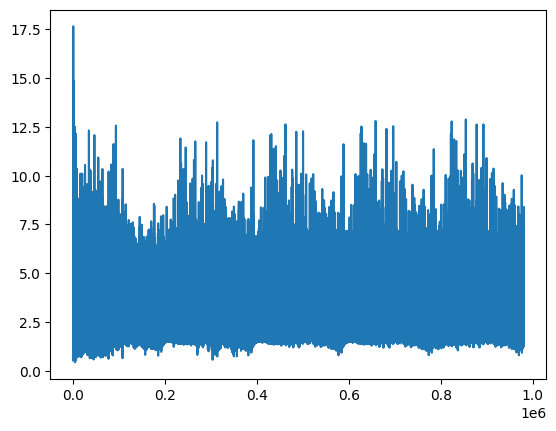

In [112]:
import matplotlib.pyplot as plt
plt.plot(stepi, lossi)

In [133]:
# i_x = torch.randint(0, len(x), size = 32)
i_x = torch.randint(low=0, high=len(x), size=(32,))

In [134]:
i_x

tensor([ 32963, 144743, 119993, 141245, 142356,  30543, 170797,  60479,  66972,
         18435, 111616,  73890, 156155, 184187,  75307, 112800,   8874,  64210,
         16742, 106843, 169531, 168398, 152023, 190885,   1838,  22774, 109002,
         40770,  45579,  73840, 171641,  17350])

In [135]:
x[i_x]
y[i_x]

tensor([22, 14, 14,  3,  8, 13, 25, 18, 10,  1, 22,  5, 14,  9,  1,  5,  2,  5,
        19,  9, 11,  1,  9,  8, 12,  1, 15, 14,  1, 13,  8, 12])

In [185]:
#training loop
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = F.cross_entropy

lossi = []
stepi = []
counter = 0

model.train()
for epoch in range (400):
        i_x = torch.randint(low=0, high=len(x), size=(1024*8,))
        input_data = x[i_x]
        output_data = y[i_x]
        predict = model(input_data)
        loss = criterion(predict, output_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
        stepi.append(counter)
        counter += 1


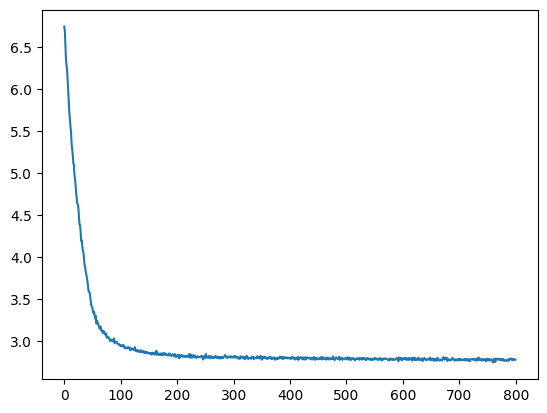

In [187]:
plt.plot(stepi,lossi)

In [184]:
model.eval()

input_chars = ['o', 'l', 'i']
input_vals = torch.tensor([[s2i[c] for c in input_chars]], dtype=torch.float32)  

result = input_chars.copy()

for _ in range(3):  
    output = model(input_vals)  
    probs = F.softmax(output.squeeze(), dim=0) 
    next_idx = torch.multinomial(probs, 1).item()
    next_char = i2s[next_idx]
    result.append(next_char)
    
    new_input = result[-3:] 
    input_vals = torch.tensor([[s2i[c] for c in new_input]], dtype=torch.float32)

generated_text = ''.join(result)
print(generated_text)

oliwed
